In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [15]:
df =  pd.read_csv('https://raw.githubusercontent.com/4yDo-l0do/Avito_AAA/main/metric/hm1/orders.csv',encoding="ISO-8859-1")
df['order_date'] = pd.to_datetime(df['order_date'],infer_datetime_format=True)
df.drop_duplicates(inplace=True)
df['InvoiceMonth'] = df['order_date'].dt.strftime('%Y-%m')
df['InvoiceYear'] = df['order_date'].dt.strftime('%Y')

In [16]:
def cohort_period(df):
    """
    Creates column CohortPeriod
    """
    df['CohortPeriod'] = np.arange(len(df))
    return df


def retation(df):
    '''
    retention rate
    '''
    
    cohorts= df.groupby('customer_id',as_index=False)['InvoiceMonth'].min()
    cohorts.rename(columns = {'InvoiceMonth':'Cohort'},inplace=True)
    
    df_merged= pd.merge(df,cohorts , how='left', on='customer_id')
    
    cohorts_group = df_merged.groupby(['Cohort', 'InvoiceMonth']).agg({'customer_id': pd.Series.nunique})
    cohorts_group.rename(columns={'customer_id': 'TotalUsers','InvoiceNo': 'TotalOrders'}, inplace=True)
    cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
    cohorts_group.reset_index(inplace=True)
    cohorts_group.set_index(['Cohort', 'CohortPeriod'], inplace=True) 
    cohort_group_size = cohorts_group['TotalUsers'].groupby(level=0).first()
    user_retention = cohorts_group['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
    user_retention = user_retention.reindex(columns=sorted(df.InvoiceMonth.unique()))
    user_retention = user_retention.round(2)
    return user_retention.T

### 1) Для начала посмотрим на количество продаж в каждом году

In [17]:
count_year=df.groupby(pd.Grouper(key="order_date", freq="Y")).count()['id']
count_year

order_date
2014-12-31     969
2015-12-31    1038
2016-12-31    1315
2017-12-31    1687
Freq: A-DEC, Name: id, dtype: int64

Видим, что общее число заказов растет

### 2) посмотрим на приток пользователей по годам 

In [18]:
new_users_in_year=df.groupby('customer_id',as_index=False)['InvoiceYear'].min()
new_users_in_year.rename(columns = {'InvoiceYear':'Cohort'},inplace=True)
new_users_in_year=new_users_in_year.groupby('Cohort',as_index=False).count()
new_users_in_year

,Cohort,customer_id
0,2014,595
1,2015,136
2,2016,51
3,2017,11


Видим, что за последние 2 года у нас маленький приток новых пользователей

### 2) Проведем когортный анализ по месяцам

In [19]:
user_retention = retation(df)

In [20]:
user_retention = user_retention.loc['2016-01':, 0:24]

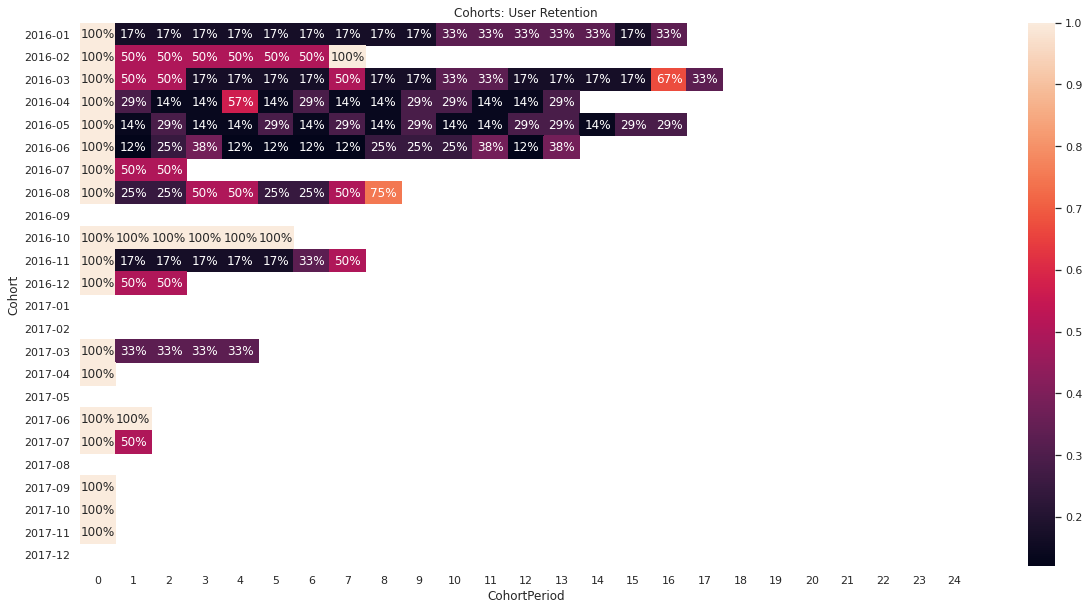

In [21]:
sns.set(style='white')
plt.figure(figsize=(20, 10))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention, mask=user_retention.isnull(), annot=True, fmt='.0%');

Видим, что пользователи, которые пришли в 2016 году имеют больший raration на начало периода и дольше сохраняют интерес к нашему магазину, чем пользователи пришедшие к нам в 2017. Но и к 2017 году rotation пользователей пришедших в 2016 падает, что не согласуется с количеством заказов в 2017 году. 

Для того чтобы разобраться в причинах нужно посмотреть на пользователей из более раннего периода.

In [22]:
user_retention = retation(df)

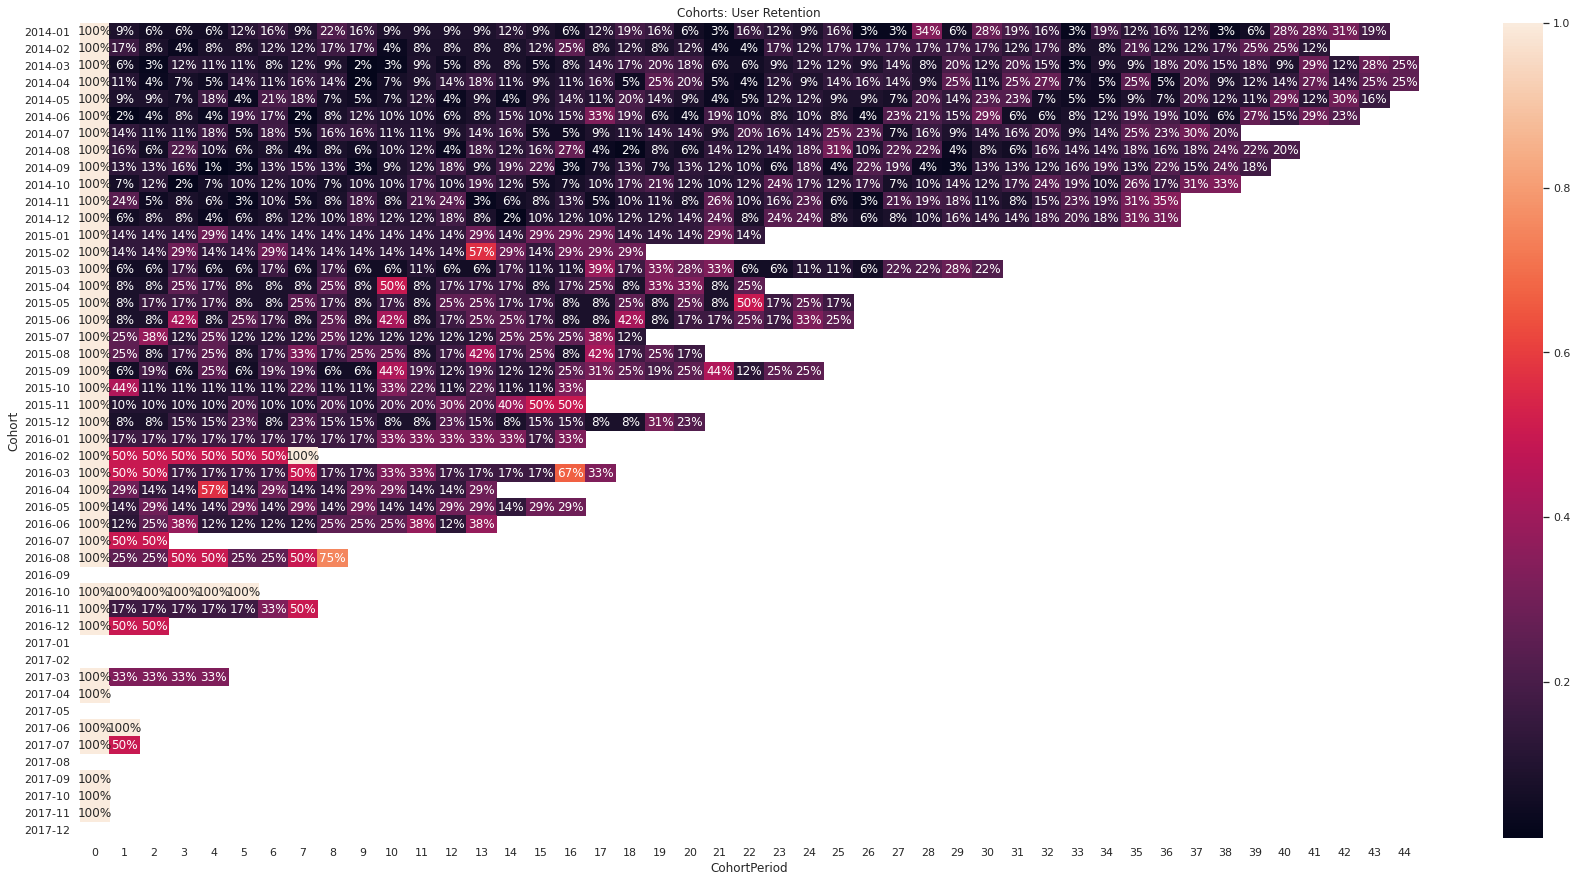

In [23]:
sns.set(style='white')
plt.figure(figsize=(30, 15))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention, mask=user_retention.isnull(), annot=True, fmt='.0%');

Видим, что старые пользователе в 2017 году начинают покупать чаще чем в 2016.

### 3) Проведем когортный анализ по годам

In [24]:
def retation_Year(df):
    '''
    retention rate
    '''
    
    cohorts= df.groupby('customer_id',as_index=False)['InvoiceYear'].min()
    cohorts.rename(columns = {'InvoiceYear':'Cohort'},inplace=True)
    
    df_merged= pd.merge(df,cohorts , how='left', on='customer_id')
    
    cohorts_group = df_merged.groupby(['Cohort', 'InvoiceYear']).agg({'customer_id': pd.Series.nunique})
    cohorts_group.rename(columns={'customer_id': 'TotalUsers','InvoiceNo': 'TotalOrders'}, inplace=True)
    cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
    cohorts_group.reset_index(inplace=True)
    cohorts_group.set_index(['Cohort', 'CohortPeriod'], inplace=True) 
    cohort_group_size = cohorts_group['TotalUsers'].groupby(level=0).first()
    user_retention = cohorts_group['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
    user_retention = user_retention.reindex(columns=sorted(df.InvoiceYear.unique()))
    user_retention = user_retention.round(2)
    return user_retention.T

In [25]:
user_retention_year=retation_Year(df)

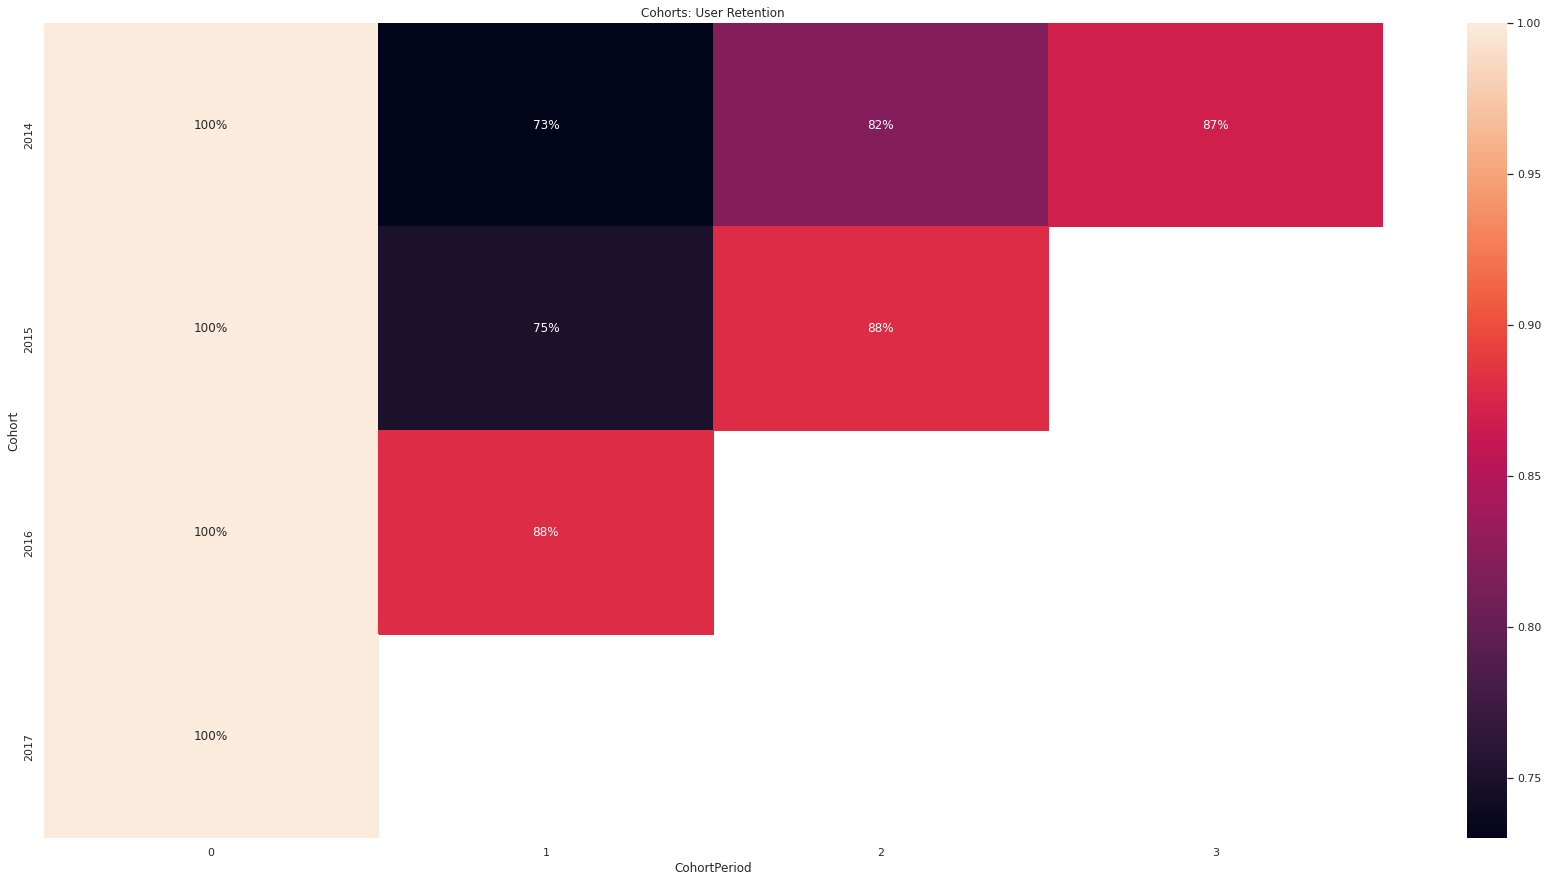

In [26]:
plt.figure(figsize=(30, 15))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention_year, mask=user_retention_year.isnull(), annot=True, fmt='.0%');

Если посмотреть на диагонали, то можно увидеть, что в 2017-м году к нам возвращается больше пользователей, чем в 2016-м. Гипотезу руководителя можно отвергнуть.

## Выводы

1) Гипотеза о том, что в магазине у нас стали больше оттекать пользователи не верна. Процент старых пользователей которые вернулись к нам за покупками наоборот растет.

2) Количество новых пользователей с каждым готом падает - возможно, проблема с маркетингом.

3) Число заказов с каждым годом растет, благодаря "старым" пользователям. Старе пользователи покупают чаще новых 
